In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from tqdm import tqdm

from typing import List
from collections import Counter
from itertools import chain
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [4]:
reviews = pd.read_csv('shopee_reviews.csv')
reviews.columns = ['mark', 'review']
reviews.head()

,mark,review
0,5,Looks ok. Not like so durable. Will hv to use ...
1,5,"Tried, the current can be very powerful depend..."
2,5,Item received after a week. Looks smaller than...
3,5,Thanks!!! Works as describe no complaints. Not...
4,5,Fast delivery considering it’s from overseas a...


In [5]:
def build_vocab(reviews: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in reviews]))
    vocab = Counter(words)
    return vocab

In [6]:
res = pd.DataFrame(columns=['mark', 'review'])
for mark in range(1, 5 + 1):
    res = res.append(reviews[reviews.mark == mark].sample(10000), ignore_index=True)
reviews = res

In [50]:
vocab = build_vocab(reviews.review.tolist())
print(len(vocab))
list(vocab.items())[:10]

48186


[('Item', 3532),
 ('received', 5456),
 ('is', 22070),
 ('torn,', 27),
 ('can’t', 459),
 ('get', 1334),
 ('replacement', 105),
 ('or', 1413),
 ('exchange', 152),
 ('from', 3661)]

In [9]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [10]:
eng_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [11]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    cleaned_words = []
    for word in text.split():
        if word in eng_stopwords:
            continue
        cleaned_words.append(stemmer.stem(word))

    return ' '.join(cleaned_words)


texts = []
for text in tqdm(reviews.review.tolist()):
    texts.append(preprocess_text(text))
vocab = build_vocab(texts)
        
print(len(vocab))
vocab.most_common(10)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:10<00:00, 4956.36it/s]


17875


[('good', 11662),
 ('receiv', 11099),
 ('item', 9942),
 ('deliveri', 8681),
 ('seller', 7061),
 ('order', 5878),
 ('qualiti', 5814),
 ('size', 5151),
 ('fast', 4941),
 ('product', 4698)]

In [12]:
cleaned_vocab = list(filter(lambda x: x[1] > 3, vocab.items()))
cleaned_words = [k for k, v in cleaned_vocab]
print(len(cleaned_words))

4560


In [14]:
from gensim.models import Word2Vec

def filtered_text(text):
    return list(filter(lambda word: word in cleaned_words, text.split()))

model = Word2Vec(sentences=[filtered_text(text) for text in tqdm(texts)],
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=40, 
                 min_count=1
                 )
print('размерность векторов слов в модели:', model.wv.vectors.shape)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7210.34it/s]


размерность векторов слов в модели: (4560, 100)


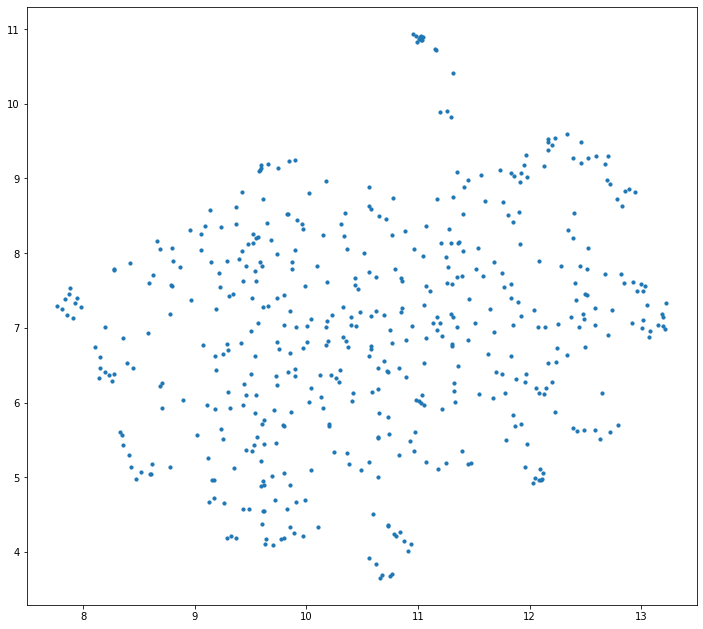

In [15]:
points = umap.UMAP(random_state=42).fit_transform(model.wv.vectors[:500])
plt.figure(figsize=(12, 11))
plt.scatter(x=points[:, 0], y=points[:, 1], s=10)

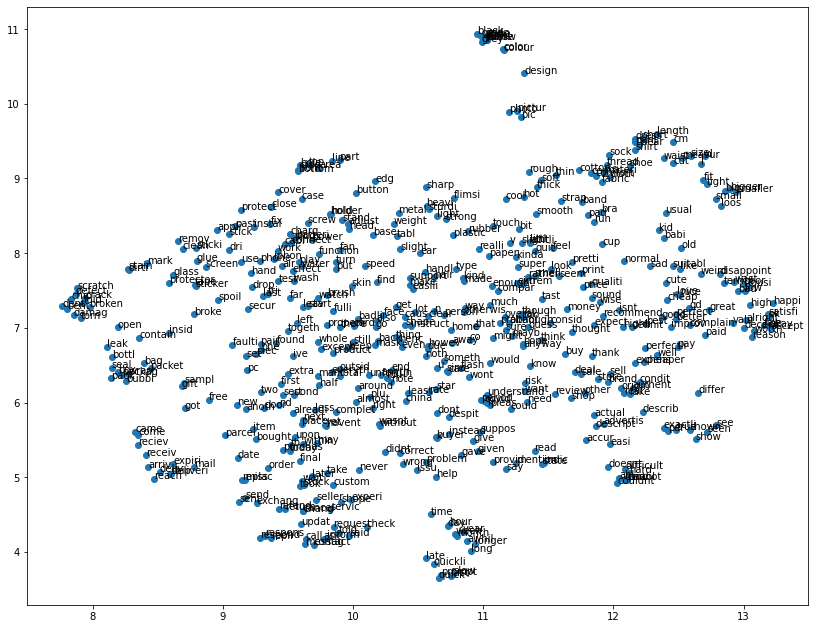

In [16]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(model.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class Utils:
    
    def __init__(self, words, word_to_vec_f):
        self.words_dict = dict(zip(words, range(len(words))))
        self.converter = word_to_vec_f
        self.cosin_matrix = self.build_cosine_matrix(words, word_to_vec_f)
        
    def get_embed(self, word):
        return self.converter(word)
        
    def build_cosine_matrix(self, words, func):
        np_words = np.array([func(word) for word in tqdm(words)])
        return cosine_similarity(np_words, np_words)

    def common(self, word1, word2, f):
        a, b = np.array(self.converter(word1)), np.array(self.converter(word2))
        return f(a, b)
    
    def subwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a+b)

    def sumwords(self, word1, word2):
        return self.common(word1, word2, lambda a, b: a+b)
    
    def similar_helper(self, vector):
        temp = [(w, cosine_similarity([self.converter(w)], [vector])[0][0]) for w in self.words_dict.keys()]
        temp.sort(key=lambda x:-x[1])
        return temp
    
    def similar(self, vector, count=1):
        temp = self.similar_helper(vector)
        return temp[2:2+count]
    
    def unsimilar(self, vector, count=1):
        temp = self.similar_helper(word)
        return sorted(temp[-count-2:-2], key=lambda x: x[1])
    
    def close_helper(self, word):
        word_index = self.words_dict[word]
        temp = [(i, w, self.cosin_matrix[word_index][i]) for w, i in filter(lambda x: x[0] != word, self.words_dict.items())]
        temp.sort(key=lambda x:-x[2])
        return temp
    
    def close(self, word, count=1):
        temp = self.close_helper(word)
        return temp[:count]
    
    def unclose(self, word, count=1):
        temp = self.close_helper(word)
        return sorted(temp[-count:], key=lambda x: x[2])

In [20]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model_bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model_bert.eval()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [21]:
len(list(tokenizer.vocab.keys()))

30522

In [22]:
gensim_utils = Utils(cleaned_words, model.wv.get_vector)

100%|██████████████████████████████████████████████████████████████████████████| 4560/4560 [00:00<00:00, 381004.13it/s]


In [23]:
def make_word_embedding(word: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(word)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    return outputs[2][-1].squeeze(0).sum(dim=0).tolist()

bert_utils = Utils(cleaned_words, make_word_embedding)

100%|██████████████████████████████████████████████████████████████████████████████| 4560/4560 [04:10<00:00, 18.22it/s]


In [24]:
gensim_utils.sumwords("green", "blue")

array([-3.0556302 , -3.8544717 ,  2.41571   ,  0.84324574, -0.8773493 ,
        1.7616944 , -2.224405  , -0.70419866,  3.853876  ,  6.1977334 ,
        3.9703743 ,  1.1325703 , -1.2736115 , -1.4056263 ,  3.4727535 ,
        4.600444  ,  5.506703  , -0.42793223, -1.2696185 ,  0.27940634,
        2.1530032 ,  0.07365111, -2.4727726 , -1.2871404 ,  0.5649471 ,
        0.2216981 ,  5.0562325 ,  0.39525732,  3.9621625 , -0.9869816 ,
        2.9349287 ,  0.27386636, -2.2713387 , -0.7571304 , -2.4509804 ,
       -1.2154051 , -5.147221  ,  0.3348246 ,  1.3763218 , -0.07466322,
        0.99636495,  2.1203685 , -3.0112798 , -1.364093  ,  4.7385077 ,
        3.468691  ,  2.591837  ,  0.08880346,  1.775201  , -1.8669523 ,
        0.27603155, -4.52926   , -0.8415036 , -2.2055206 , -3.3823562 ,
       -4.072745  ,  0.13056864,  0.15545234,  0.01310527,  1.7500664 ,
       -2.1404362 , -2.4603035 ,  2.2419872 , -1.3281072 ,  1.9040858 ,
        0.7383694 ,  2.4527075 , -2.1560533 , -1.0862452 ,  1.29

In [25]:
bert_utils.sumwords("green", "blue")

array([-2.03890357e-01, -3.25582027e-02, -1.65934688e+00,  4.32028905e-01,
        1.07174098e-01,  2.94315763e-01,  1.46815777e+00,  1.61790991e+00,
       -1.03367838e+00, -2.32995749e-02, -6.06430322e-02, -1.72204095e+00,
       -9.33521450e-01,  2.94943631e-01, -2.77580772e-01,  1.59480321e+00,
        9.20771524e-01, -4.81474847e-01, -2.61455715e-01, -6.39876842e-01,
        4.63211149e-01, -1.19270909e+00, -2.72331424e-01,  6.39087260e-02,
       -4.17434931e-01, -7.71860838e-01, -4.24020126e-01, -6.67120144e-02,
       -6.62745953e-01, -5.25295675e-01,  3.87879565e-01, -1.03553671e+00,
        1.69458091e-01, -5.36643371e-01,  4.98879999e-01,  1.93465757e+00,
        1.30997166e-01, -9.09211278e-01, -1.46233743e+00, -4.48312551e-01,
        1.93121403e-01, -2.18490459e-01, -6.38116956e-01,  2.37198770e-01,
        5.40056854e-01,  6.23120785e-01,  1.34345400e+00,  1.77018687e-01,
       -1.82510883e-01, -7.38511413e-01,  4.30099517e-02,  1.18255764e+00,
        1.18184465e+00, -

In [30]:
gensim_utils.similar(gensim_utils.subwords("good", "fast"), count = 5)

[('quick', 0.69324934),
 ('prompt', 0.62247896),
 ('speedi', 0.5957551),
 ('excel', 0.53702193),
 ('great', 0.53318506)]

In [31]:
bert_utils.similar(bert_utils.subwords("good", "fast"), count = 5)

[('goodi', 0.8180294600285098),
 ('goodfast', 0.7801272128375145),
 ('hardli', 0.765693200548435),
 ('goodgood', 0.7490852613202066),
 ('skip', 0.742152810130057)]

In [37]:
gensim_utils.close("good", count=10)

[(1244, 'great', 0.7086842),
 (463, 'gd', 0.64310324),
 (103, 'bad', 0.573548),
 (1758, 'excel', 0.56607807),
 (734, 'ok', 0.5228502),
 (2223, 'decent', 0.51201755),
 (381, 'nice', 0.50377774),
 (1321, 'okay', 0.489944),
 (2186, 'alright', 0.48138797),
 (1816, 'satisfactori', 0.47715706)]

In [38]:
bert_utils.close("good", count=10)

[(3801, 'goodwil', 0.8346412545212377),
 (3186, 'goodi', 0.8302492921281555),
 (4499, 'goodthank', 0.7717763450124447),
 (4550, 'goodgood', 0.7717021916885012),
 (4197, 'goodfast', 0.7462025914399172),
 (2956, 'goodbut', 0.7310788679270642),
 (2460, 'vid', 0.7208085786048952),
 (4269, 'boyish', 0.7195082214313216),
 (922, 'goodveri', 0.7158323318322025),
 (2441, 'bird', 0.712067016408946)]

In [39]:
corpus_vocab = sorted(cleaned_vocab, key=lambda x: -x[1])[:2000]
print(corpus_vocab[:10])
corpus = [i[0] for i in corpus_vocab]

[('good', 11662), ('receiv', 11099), ('item', 9942), ('deliveri', 8681), ('seller', 7061), ('order', 5878), ('qualiti', 5814), ('size', 5151), ('fast', 4941), ('product', 4698)]


In [40]:
embeddings = [gensim_utils.get_embed(i) for i in corpus]
print(embeddings[0])

[-0.86790603  0.34575945  0.04562286 -0.42548367 -0.15252009  0.6390495
 -0.8658287   0.08001363 -2.1565666  -0.5314944  -0.58555794  0.18780415
  0.4232976   0.5117171  -0.4362177  -0.5355606  -0.23060815 -0.52438974
  1.0891061   1.3141912  -0.47325125 -0.46222588 -0.52502376 -0.39339498
 -0.75504065 -0.7606831  -0.41841227 -0.92675424  0.76221246  0.5248146
 -2.085689   -0.27019417 -0.82036805  0.44910625  0.6213267  -1.880762
  0.06376483  0.6716541  -0.28172505 -0.32229573 -0.14339809  1.0113692
  1.6936386  -0.34503284 -0.54183567  0.09236759  1.2266212   0.04043097
  0.8387589   0.0214288  -0.9034509  -0.7508248   0.5648428  -0.27258086
 -0.30150518  0.310725    1.2469286  -0.23946576 -1.4966385   1.672934
 -0.6245572  -0.900663    1.2102206   0.74127007 -1.0410709  -1.4684714
  1.1756206  -0.3598078  -0.2263854   0.9684788  -0.7054198   0.13187763
 -0.32379937 -0.37442863 -0.7440686  -0.9490383  -1.0543798   1.5104153
  0.25013277  1.5961996  -0.06408002  0.6054649  -0.9410776 

In [43]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

writer.add_embedding(embeddings,
                     metadata=corpus)
writer.close()

In [44]:
%load_ext tensorboard

In [47]:
%tensorboard --logdir runs --bind_all --port 7012

Reusing TensorBoard on port 7012 (pid 24216), started 0:00:33 ago. (Use '!kill 24216' to kill it.)